In [1]:
import pandas as pd
import numpy as np
import re
import string

data = pd.read_csv("/kaggle/input/1202artikel/1202ArtikelNER.csv", encoding="latin1")

In [2]:
data

,Artikel,Kalimat,Teks,Tag
0,Artikel1,Kalimat1,ketua,O
1,NaN,Kalimat1,umum,O
2,NaN,Kalimat1,pan,B-ORG
3,NaN,Kalimat1,zulkifli,B-PER
4,NaN,Kalimat1,hasan,I-PER
...,...,...,...,...
125948,NaN,Kalimat5439,istana,O
125949,NaN,Kalimat5439,jelang,O
125950,NaN,Kalimat5439,pelantikan,O
125951,NaN,Kalimat5439,menko,B-ORG


In [3]:
tag_counts = data["Tag"].value_counts()
tag_counts

O        103526
B-PER      7020
B-ORG      3761
I-PER      3372
B-LOC      3127
B-TIM      1757
I-ORG      1677
I-TIM       925
I-LOC       679
Name: Tag, dtype: int64

In [4]:
data = data.fillna(method="ffill")

In [5]:
data.head(50)

,Artikel,Kalimat,Teks,Tag
0,Artikel1,Kalimat1,ketua,O
1,Artikel1,Kalimat1,umum,O
2,Artikel1,Kalimat1,pan,B-ORG
3,Artikel1,Kalimat1,zulkifli,B-PER
4,Artikel1,Kalimat1,hasan,I-PER
5,Artikel1,Kalimat1,(,O
6,Artikel1,Kalimat1,zulhas,B-PER
7,Artikel1,Kalimat1,),O
8,Artikel1,Kalimat1,optimistis,O
9,Artikel1,Kalimat1,pan,B-ORG


In [6]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

9

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        # Aggregating sentences by "Kalimat" column
        agg_func = lambda s: [(te, ta) for te, ta in zip(s["Teks"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Kalimat").apply(agg_func).to_dict()
        self.sentences = [s for s in self.grouped.values()]

        # Debug print to check the sentences
        print("Sample sentences:")
        for i, s in enumerate(self.sentences[:2]):  # Check first two sentences
            print(f"Sentence {i}: {s}")

    def get_next(self):
        try:
            s = self.grouped[f'Kalimat{self.n_sent}']
            self.n_sent += 1
            return s
        except KeyError:
            print(f"Sentence number {self.n_sent} not found.")  # Debug print
            return None

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

Sample sentences:
Sentence 0: [('ketua', 'O'), ('umum', 'O'), ('pan', 'B-ORG'), ('zulkifli', 'B-PER'), ('hasan', 'I-PER'), ('(', 'O'), ('zulhas', 'B-PER'), (')', 'O'), ('optimistis', 'O'), ('pan', 'B-ORG'), ('dan', 'O'), ('gibran', 'B-PER'), ('prabowo', 'B-PER'), ('bisa', 'O'), ('menang', 'O'), ('di', 'O'), ('tegal', 'B-LOC'), ('.', 'O')]
Sentence 1: [('balikpapan', 'B-LOC'), ('kasihan', 'O'), (',', 'O'), ('banjarmasin', 'B-LOC'), ('kasihan', 'O'), (',', 'O'), ('pontianak', 'B-LOC'), ('kasihan', 'O'), (',', 'O'), ('karena', 'O'), ('apa', 'O'), ('?', 'O'), ('gerakan', 'O'), ('biru', 'O'), ('kuning', 'O'), ('(', 'O'), ('gbk', 'O'), (')', 'O'), ('jawa', 'B-LOC'), ('tengah', 'I-LOC'), ('mendeklarasikan', 'O'), ('dukungan', 'O'), ('kepada', 'O'), ('pasangan', 'O'), ('capres-cawapres', 'O'), ('anies', 'B-PER'), ('baswedan', 'I-PER'), ('dan', 'O'), ('muhaimin', 'B-PER'), ('iskandar', 'I-PER'), ('(', 'O'), ('amin', 'O'), (')', 'O'), ('.', 'O')]


In [9]:
sent = getter.get_next()
print("Sentence 1:", sent)

Sentence 1: [('ketua', 'O'), ('umum', 'O'), ('pan', 'B-ORG'), ('zulkifli', 'B-PER'), ('hasan', 'I-PER'), ('(', 'O'), ('zulhas', 'B-PER'), (')', 'O'), ('optimistis', 'O'), ('pan', 'B-ORG'), ('dan', 'O'), ('gibran', 'B-PER'), ('prabowo', 'B-PER'), ('bisa', 'O'), ('menang', 'O'), ('di', 'O'), ('tegal', 'B-LOC'), ('.', 'O')]


## Prepare the data
Now we introduce dictionaries of words and tags.

In [10]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [11]:
# Extract words from sentences
sentences_words = [[w[0] for w in s] for s in sentences]

# Train Word2Vec model (CBOW)
w2v_model = Word2Vec(sentences=sentences_words, size=100, window=5, min_count=1, sg=0)

# Create a dictionary for word embeddings
get_word_embedding = {word: w2v_model.wv[word] for word in w2v_model.wv.index2word}

In [12]:
# Urutan tag yang diinginkan
desired_order = ['PAD', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-TIM', 'I-TIM', 'O']

# Membuat mapping tag ke indeks sesuai urutan yang diinginkan, mulai dari 0
tag2idx = {t: i for i, t in enumerate(desired_order)}

# Menghitung jumlah tag, termasuk indeks 0 untuk padding jika diperlukan
n_tags = len(desired_order)

print("Tag to Index Mapping:", tag2idx)
print("Number of Tags:", n_tags)

Tag to Index Mapping: {'PAD': 0, 'B-ORG': 1, 'I-ORG': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-TIM': 7, 'I-TIM': 8, 'O': 9}
Number of Tags: 10


In [13]:
X = [[get_word_embedding[w[0]] for w in s] for s in sentences]

In [14]:
y = []
for i, s in enumerate(sentences):
    sentence_tags = []
    for j, w in enumerate(s):
        if len(w) != 2:
            print(f"Invalid data format at sentence {i}, word index {j}: {w}")  # Debug print
            sentence_tags.append(tag2idx['O'])  # Append default tag for incorrect format
        else:
            word, tag = w
            if tag not in tag2idx:
                print(f"Tag '{tag}' not in tag2idx.")  # Debug print
                sentence_tags.append(tag2idx['O'])  # Append default tag for unknown tag
            else:
                sentence_tags.append(tag2idx[tag])
    y.append(sentence_tags)

In [15]:
# import pickle

# # Simpan data embedding ke file .pkl
# with open("embeddings2.pkl", "wb") as f:
#     pickle.dump(X, f)

# print("Data embedding telah disimpan dan dimuat kembali.")

Data embedding telah disimpan dan dimuat kembali.


In [15]:
print("Sample sentences data:")
for i, s in enumerate(sentences[:2]):
    print(f"Sentence {i}: {s}")

Sample sentences data:
Sentence 0: [('ketua', 'O'), ('umum', 'O'), ('pan', 'B-ORG'), ('zulkifli', 'B-PER'), ('hasan', 'I-PER'), ('(', 'O'), ('zulhas', 'B-PER'), (')', 'O'), ('optimistis', 'O'), ('pan', 'B-ORG'), ('dan', 'O'), ('gibran', 'B-PER'), ('prabowo', 'B-PER'), ('bisa', 'O'), ('menang', 'O'), ('di', 'O'), ('tegal', 'B-LOC'), ('.', 'O')]
Sentence 1: [('balikpapan', 'B-LOC'), ('kasihan', 'O'), (',', 'O'), ('banjarmasin', 'B-LOC'), ('kasihan', 'O'), (',', 'O'), ('pontianak', 'B-LOC'), ('kasihan', 'O'), (',', 'O'), ('karena', 'O'), ('apa', 'O'), ('?', 'O'), ('gerakan', 'O'), ('biru', 'O'), ('kuning', 'O'), ('(', 'O'), ('gbk', 'O'), (')', 'O'), ('jawa', 'B-LOC'), ('tengah', 'I-LOC'), ('mendeklarasikan', 'O'), ('dukungan', 'O'), ('kepada', 'O'), ('pasangan', 'O'), ('capres-cawapres', 'O'), ('anies', 'B-PER'), ('baswedan', 'I-PER'), ('dan', 'O'), ('muhaimin', 'B-PER'), ('iskandar', 'I-PER'), ('(', 'O'), ('amin', 'O'), (')', 'O'), ('.', 'O')]


In [16]:
print("X sample:", X[0])  # Example word embeddings for the first sentence
print("y sample:", y[0])  # Example tag indices for the first sentence

X sample: [array([ 0.09923386, -0.28640023,  0.15170297, -0.08267568,  0.18751203,
       -0.22650568, -0.63749105,  0.5782555 , -0.84941596,  1.5935297 ,
       -0.61341447,  0.21207426, -0.13813609,  0.07058504, -0.6326859 ,
        0.42102927, -0.16384475,  0.54148114, -0.24422339, -0.14619505,
       -0.3907189 , -0.16339545, -0.04218259,  0.4153419 ,  0.6159502 ,
       -0.22571579,  1.0699773 ,  0.18446232,  0.31739894,  0.16947284,
        1.0180112 ,  0.59596646,  0.48375443, -0.9582521 ,  1.2151388 ,
       -0.8755146 , -0.3717825 ,  0.28179342,  0.3881791 ,  0.04720329,
       -0.38649955, -0.47898853,  0.41446292, -0.70328397,  0.95850027,
       -0.11597887, -1.6687481 ,  0.59315205,  1.2438526 ,  1.2576647 ,
       -0.6371429 ,  0.34203112, -0.06710645, -0.315794  ,  0.32945174,
       -0.04722434, -0.79024434, -1.0815587 ,  1.0023625 , -0.16343531,
       -1.4246364 , -1.1914389 ,  0.17665899, -0.4730421 , -0.7534189 ,
        0.2836191 , -0.7301761 ,  1.354252  ,  0.1456

In [17]:
max_len = 150
X_padded = pad_sequences(X, maxlen=max_len, padding='post')
y_padded = pad_sequences(y, maxlen=max_len, padding='post')

In [18]:
print("Shape of X_padded:", X_padded.shape)
print("Shape of y_padded:", y_padded.shape)

Shape of X_padded: (5439, 150, 100)
Shape of y_padded: (5439, 150)


In [20]:
# np.save('S2X_padded.npy', X_padded)
# np.save('S2y_padded.npy', y_padded)

In [19]:
# Periksa jumlah kelas, termasuk padding
num_classes = max(n_tags, max(y_padded.flatten()) + 1)

In [20]:
y_resampled_onehot = np.array([to_categorical(i, num_classes=num_classes) for i in y_padded])

In [15]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git -q

In [16]:
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
from sklearn.metrics import classification_report, confusion_matrix
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import keras as k
import time
from keras.initializers import glorot_uniform
from keras.optimizers import RMSprop

## Model

In [25]:
def save_model(model, fold, best=False):
    model_path = f"model_fold_{fold}.h5"
    if best:
        model_path = "best_model.h5"
    model.save(model_path)
    print(f"Model for fold {fold} saved as {model_path}")

def plot_accuracy(history, fold, best=False):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['crf_accuracy'])
    plt.plot(history.history['val_crf_accuracy'])
    plt.title(f'Model accuracy - Fold {fold}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plot_path = f"accuracy_fold_{fold}.png"
    if best:
        plot_path = "best_accuracy.png"
    plt.savefig(plot_path)
#     plt.show()

def plot_loss(history, fold, best=False):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - Fold {fold}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plot_path = f"loss_fold_{fold}.png"
    if best:
        plot_path = "best_loss.png"
    plt.savefig(plot_path)


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y_resampled_onehot, test_size=0.1, random_state=42)

Fold 1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 100)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 300)          301200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 50)           15050     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 150, 10)           510       
_________________________________________________________________
crf_1 (CRF)                  (None, 150, 10)           230       
Total params: 316,990
Trainable params: 316,990
Non-trainable params: 0
______________________________________________

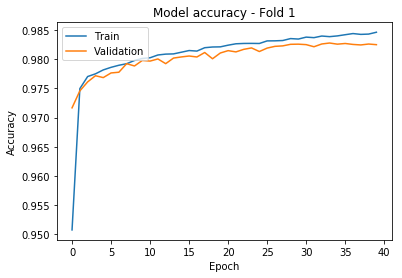

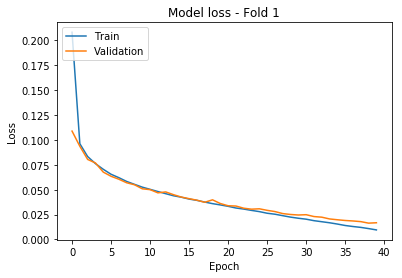

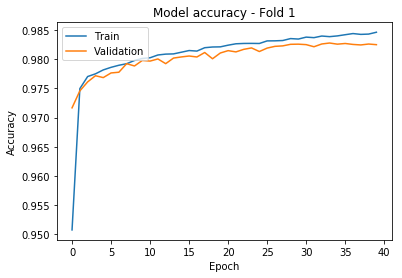

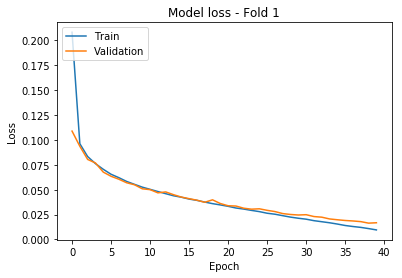

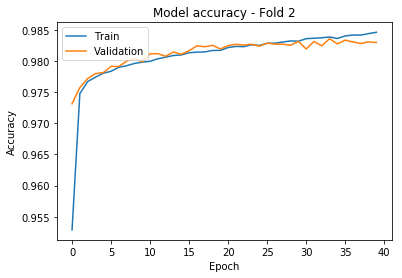

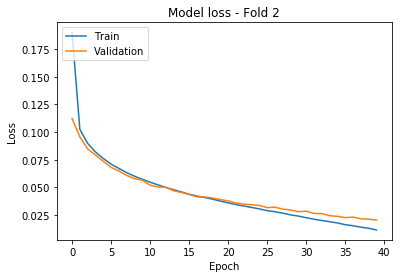

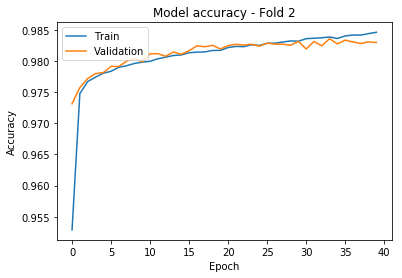

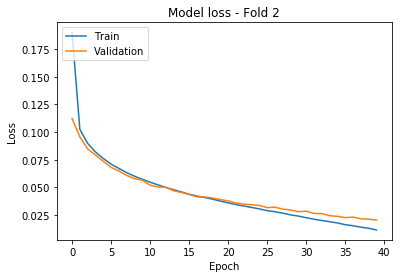

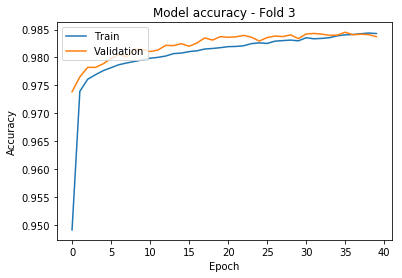

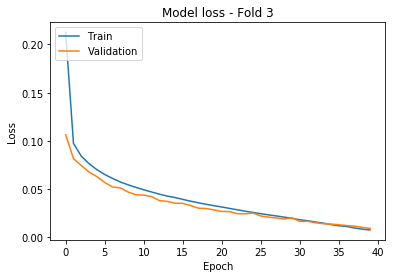

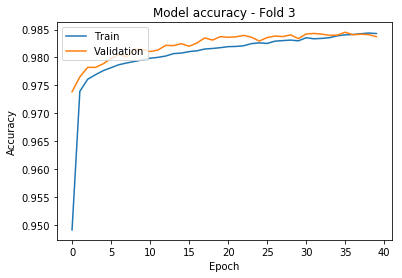

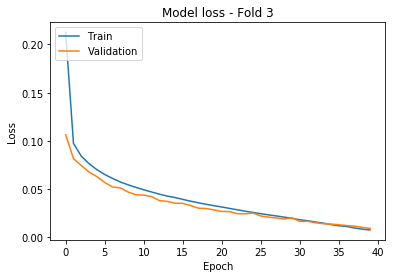

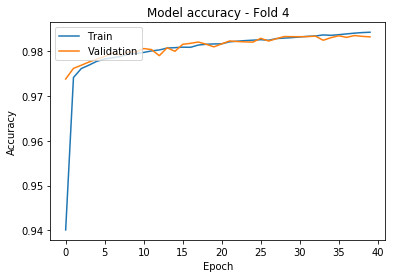

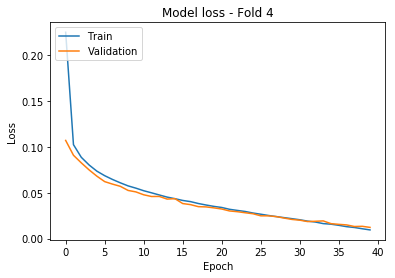

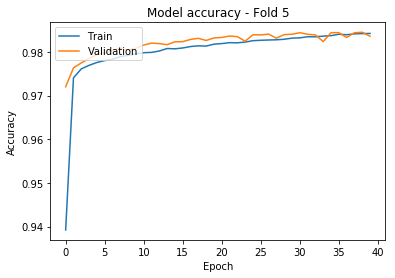

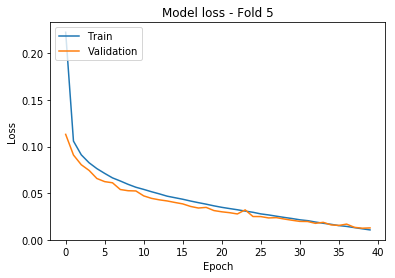

In [27]:
all_y_true_flat = []
all_y_pred_flat = []
best_val_accuracy = 0
best_fold = 0
results = []

kf = KFold(n_splits=5, shuffle=True)

fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"Fold {fold}")
    X_tr, X_val = X_padded[train_index], X_padded[val_index]
    y_tr, y_val = y_resampled_onehot[train_index], y_resampled_onehot[val_index]
    
    # Arsitektur Model
    inputs = Input(shape=(max_len, w2v_model.vector_size))
    x = Dropout(0.2)(inputs)  
    bilstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.2, kernel_initializer=glorot_uniform(seed=42)))(x)
    x = TimeDistributed(Dense(50, activation='relu'))(bilstm)  
    x = TimeDistributed(Dense(n_tags))(x) 
    crf_layer = CRF(n_tags)
    outputs = crf_layer(x)

    model = Model(inputs, outputs)
    model.summary()
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss=crf_loss, metrics=[crf_accuracy])
    
  
    start_time = time.time()
    history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=40, validation_data=(X_val, np.array(y_val)), verbose=1)
    end_time = time.time()
    total_time = end_time - start_time

    # Simpan hasil epoch, akurasi, dll.
    fold_results = {
        'fold': fold,
        'epoch': list(range(1, len(history.history['loss']) + 1)),
        'accuracy': history.history['crf_accuracy'],
        'val_accuracy': history.history['val_crf_accuracy'],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'total_time': total_time
    }
    results.append(fold_results)

    # Simpan model
    model.save(f'model_fold{fold}.h5')

    # Simpan hasil prediksi dan label sebenarnya dari fold ini
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_val, axis=-1)

    y_pred_flat = y_pred.flatten()
    y_true_flat = y_true.flatten()

    all_y_true_flat.extend(y_true_flat)
    all_y_pred_flat.extend(y_pred_flat)

    # Cek apakah akurasi validasi dari fold ini adalah yang terbaik
    val_accuracy = history.history['val_crf_accuracy'][-1]
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_fold = fold
        save_model(model, fold, best=True)
        plot_accuracy(history, fold, best=True)
        plot_loss(history, fold, best=True)

    # Visualisasi hasil pelatihan
    plot_accuracy(history, fold)
    plot_loss(history, fold)
    
    class_names = list(tag2idx.keys())

    # Pastikan semua kelas sudah ada di tag2idx
    assert len(class_names) == n_tags

    # Tampilkan laporan klasifikasi
    print(f"Classification Report for Fold {fold}:")
    print(classification_report(y_true_flat, y_pred_flat, target_names=class_names,digits=4, ))
    
    
    fold += 1

# Simpan hasil ke dalam file Excel
all_results = []
for fold_result in results:
    for epoch, acc, val_acc, loss, val_loss in zip(fold_result['epoch'], fold_result['accuracy'], fold_result['val_accuracy'], fold_result['loss'], fold_result['val_loss']):
        all_results.append([fold_result['fold'], epoch, acc, val_acc, loss, val_loss, fold_result['total_time']])

df = pd.DataFrame(all_results, columns=['Fold', 'Epoch', 'Accuracy', 'Val_Accuracy', 'Loss', 'Val_Loss', 'Total_Time'])
df.to_excel('training_results.xlsx', index=False)

In [28]:
# Tampilkan laporan klasifikasi keseluruhan setelah k-fold cross validation selesai
print("Overall Classification Report:")
print(classification_report(all_y_true_flat, all_y_pred_flat, target_names=class_names, digits=4))

Overall Classification Report:
              precision    recall  f1-score   support

         PAD     0.9991    0.9997    0.9994    620607
       B-ORG     0.6510    0.3207    0.4297      3542
       I-ORG     0.6577    0.4875    0.5599      1600
       B-PER     0.8793    0.6156    0.7242      6345
       I-PER     0.7695    0.6043    0.6769      3055
       B-LOC     0.6927    0.4034    0.5099      2883
       I-LOC     0.6811    0.4450    0.5383       600
       B-TIM     0.8811    0.7011    0.7809      1586
       I-TIM     0.7437    0.7133    0.7282       830
           O     0.9136    0.9740    0.9428     93202

    accuracy                         0.9833    734250
   macro avg     0.7869    0.6265    0.6890    734250
weighted avg     0.9818    0.9833    0.9817    734250



In [34]:
from keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score

In [29]:
# X = np.load('/kaggle/input/udpadd/S1X_padded.npy')
# y = np.load('/kaggle/input/udpadd/S1y_padded.npy')

In [35]:
X = np.load('/kaggle/working/S2X_padded.npy')
y = np.load('/kaggle/working/S2y_padded.npy')

In [36]:
# Converting labels to one-hot encoding
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [32]:
# best_model = load_model("/kaggle/input/modud/keras/default/1/best_model.h5", custom_objects={'CRF': CRF, 'crf_loss': crf_loss, 'crf_accuracy': crf_accuracy})

In [38]:
best_model = load_model("/kaggle/working/best_model.h5", custom_objects={'CRF': CRF, 'crf_loss': crf_loss, 'crf_accuracy': crf_accuracy})

In [39]:
#### from sklearn.metrics import classification_report, accuracy_score

# Melakukan prediksi pada set validasi
y_pred = best_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_valid, axis=-1)

# Mengubah hasil prediksi dan label sebenarnya menjadi bentuk 1D untuk laporan klasifikasi
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Membuat laporan klasifikasi
report = classification_report(y_true_flat, y_pred_flat,target_names=class_names, digits=4)
accuracy = accuracy_score(y_true_flat, y_pred_flat)

# Menampilkan laporan klasifikasi dan akurasi
print("Classification Report:\n", report)
print("Accuracy:", accuracy)


Classification Report:
               precision    recall  f1-score   support

         PAD     0.9998    0.9992    0.9995     69307
       B-ORG     0.7797    0.3844    0.5149       359
       I-ORG     0.7978    0.6121    0.6927       116
       B-PER     0.8988    0.6471    0.7525       700
       I-PER     0.8145    0.6966    0.7509       290
       B-LOC     0.7482    0.3838    0.5073       271
       I-LOC     0.8750    0.5000    0.6364        42
       B-TIM     0.9079    0.7667    0.8313       180
       I-TIM     0.7685    0.8300    0.7981       100
           O     0.9261    0.9854    0.9548     10235

    accuracy                         0.9871     81600
   macro avg     0.8516    0.6805    0.7438     81600
weighted avg     0.9864    0.9871    0.9859     81600

Accuracy: 0.9871200980392156


In [25]:
class_names = ['PAD', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-TIM', 'I-TIM', 'O']

In [48]:
# Melakukan prediksi pada set validasi
y_pred = best_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_valid, axis=-1)

In [49]:
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

array([9, 9, 9, ..., 0, 0, 0])

In [51]:
print(classification_report(y_true_flat, y_pred_flat, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         PAD     0.9631    0.9950    0.9788     69307
       B-ORG     0.0000    0.0000    0.0000       359
       I-ORG     0.0000    0.0000    0.0000       116
       B-PER     0.1613    0.0071    0.0137       700
       I-PER     0.0172    0.0241    0.0201       290
       B-LOC     0.0000    0.0000    0.0000       271
       I-LOC     0.0000    0.0000    0.0000        42
       B-TIM     0.0000    0.0000    0.0000       180
       I-TIM     0.0000    0.0000    0.0000       100
           O     0.8178    0.7634    0.7896     10235

    accuracy                         0.9410     81600
   macro avg     0.1959    0.1790    0.1802     81600
weighted avg     0.9221    0.9410    0.9306     81600



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
accuracy = accuracy_score(y_true_flat, y_pred_flat)

# Menghasilkan laporan klasifikasi
report = classification_report(y_true_flat, y_pred_flat, target_names=class_names, digits=4, output_dict=True)

# Konversi laporan klasifikasi ke DataFrame
report_df = pd.DataFrame(report).transpose()

# Menambahkan baris akurasi di bawah laporan klasifikasi
accuracy_df = pd.DataFrame({"precision": [""], "recall": [""], "f1-score": [""], "support": [""], "Accuracy": [accuracy]})
report_df = pd.concat([report_df, accuracy_df], ignore_index=False, sort=False)

# Menyimpan DataFrame ke file Excel
report_df.to_excel("classification_reporttestings2.xlsx", index=True, sheet_name='Classification Report')

print("Laporan klasifikasi dan akurasi berhasil disimpan ke classification_report.xlsx")

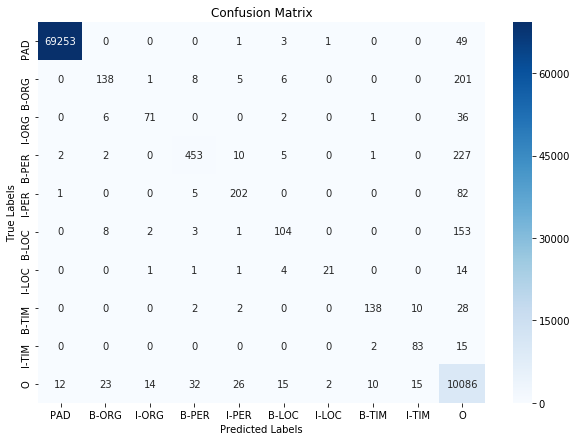

In [40]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Configuration de la taille de la figure
plt.figure(figsize=(10, 7))

# Afficher la heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Enregistrer l'image
plt.savefig('confusion_matrixfoldterbaiks2.png')  # Vous pouvez spécifier le chemin complet si nécessaire

# Afficher l'image
plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score

# Menghitung akurasi secara keseluruhan
accuracy = accuracy_score(y_true_flat, y_pred_flat)

# Menghasilkan laporan klasifikasi
report = classification_report(y_true_flat, y_pred_flat, target_names=class_names, digits=4)

# Menampilkan laporan klasifikasi dan akurasi dengan 4 angka desimal
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     69307
           1       0.00      0.00      0.00       359
           2       0.00      0.00      0.00       116
           3       0.16      0.01      0.01       700
           4       0.02      0.02      0.02       290
           5       0.00      0.00      0.00       271
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00       180
           8       0.00      0.00      0.00       100
           9       0.82      0.76      0.79     10235

    accuracy                           0.94     81600
   macro avg       0.20      0.18      0.18     81600
weighted avg       0.92      0.94      0.93     81600

Accuracy: 0.9410


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
# X = [[get_word_embedding[w[0]] for w in s if w[0] in get_word_embedding] for s in sentences]

# # Mengonversi tag dalam kalimat menjadi indeks
# y = []
# for i, s in enumerate(sentences):
#     sentence_tags = []
#     for j, w in enumerate(s):
#         if len(w) != 2:
#             print(f"Invalid data format at sentence {i}, word index {j}: {w}")  # Debug print
#             sentence_tags.append(tag2idx['O'])  # Append default tag for incorrect format
#         else:
#             word, tag = w
#             if tag not in tag2idx:
#                 print(f"Tag '{tag}' not in tag2idx.")  # Debug print
#                 sentence_tags.append(tag2idx['O'])  # Append default tag for unknown tag
#             else:
#                 sentence_tags.append(tag2idx[tag])
#     y.append(sentence_tags)

In [40]:
# y_pred = best_model.predict(X_valid)
# y_pred = np.argmax(y_pred, axis=-1)
# y_true = np.argmax(y_valid, axis=-1)

In [41]:
# for i in range(len(X)):
#     print(f"Sentence {i+1}:")
#     for j in range(len(X[i])):
#         token = sentences_words[i][j]
#         true_tag = idx2tag[y[i][j]]
#         pred_tag = idx2tag[y_pred[i][j]]
#         print(f"Token: {token:<10} True Label: {true_tag:<10} Predicted Label: {pred_tag}")
#     print()

In [42]:
# y_pred_flat = y_pred.flatten()
# y_true_flat = y_true.flatten()